In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt
from datetime import date
import dateutil.relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
inspector = inspect(engine)
columnMeasurement = inspector.get_columns('measurement')

print('Columns in measurement Table')
for column in columnMeasurement:
    print(column["name"], column["type"])
    
print('\nColumns in station Table')
columnStation = inspector.get_columns('station')
for column in columnStation:
    print(column["name"], column["type"]) 

Columns in measurement Table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Columns in station Table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
#test to see if connection works

session = Session(engine)
testQuery = session.query(Station.name).all()
testQuery

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

# Exploratory Climate Analysis

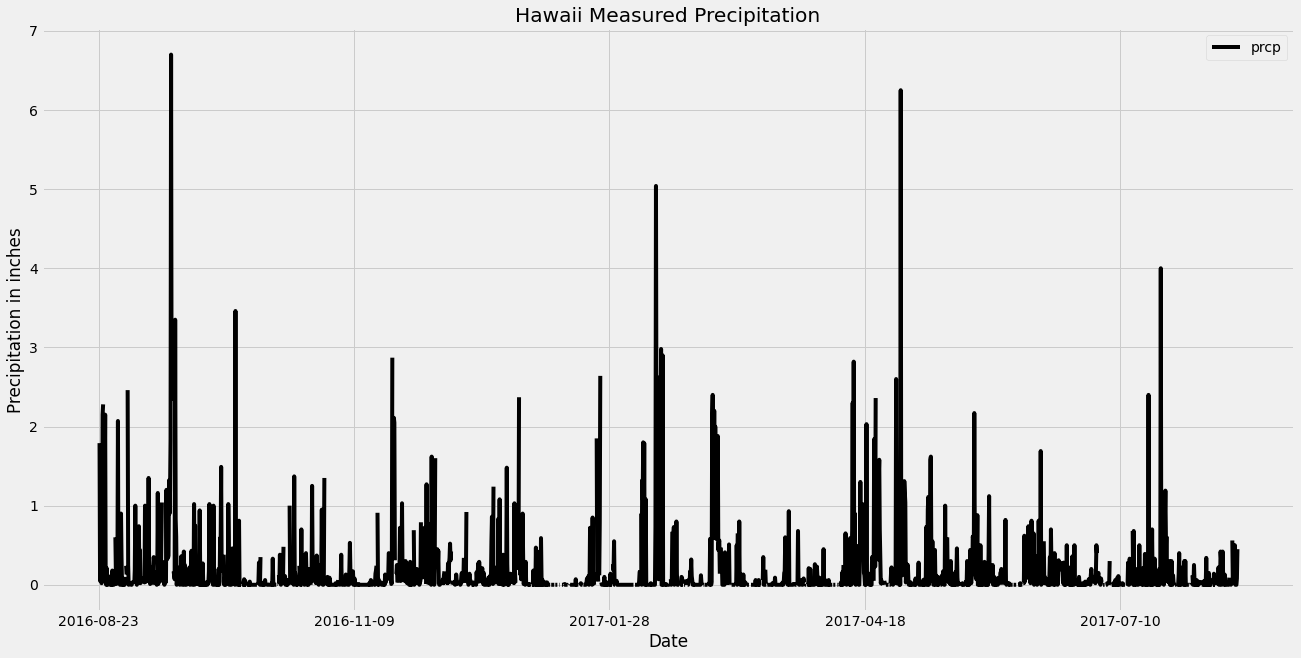

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-22').all()

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index('date')
precip_df = precip_df.sort_index()
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


ax = precip_df.plot(style='k-', figsize= (20,10), title = 'Hawaii Measured Precipitation')
ax.set_ylabel("Precipitation in inches")
ax.set_xlabel("Date")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = precip_df.describe()
summary_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
def getLastYearDate():
    """Function gets max date in dataset and returns a date 12 months in prior for queries"""
    max_date = session.query(func.max(Measurement.date)).first()
    d = dt.datetime.strptime(max_date[0], "%Y-%m-%d")
    return (d - dateutil.relativedelta.relativedelta(months=12)).strftime("%Y-%m-%d")

In [13]:
# Design a query to show how many stations are available in this dataset?
#Assuming this instruction means that dataset graphed above last 12 months and not 
# the complete dataset (instruction is not clear)
station_count = session.query(Measurement.station).distinct(Measurement.station)\
    .filter(Measurement.date > getLastYearDate()).count()

print(f'There are {station_count} unique stations reporting in the last 12 months.')

There are 7 unique stations reporting in the last 12 months.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.name, Measurement.station, func.count(Measurement.station))\
        .join(Station, Measurement.station == Station.station)\
        .filter(Measurement.date > getLastYearDate())\
        .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('WAIKIKI 717.2, HI US', 'USC00519397', 360),
 ('WAIHEE 837.5, HI US', 'USC00519281', 351),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 348),
 ('KANEOHE 838.1, HI US', 'USC00513117', 342),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 336),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 304),
 ('PEARL CITY, HI US', 'USC00517948', 182)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519397').all()
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519397').all()
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519397').all()

print(f'''For the most active station {lowest_temp[0][0]} 
the lowest recorded temp is {lowest_temp[0][1]}, the highest temp is {highest_temp[0][1]} \
and the average temp recorded is {round(float(avg_temp[0][1]),1)}.''')


For the most active station USC00519397 
the lowest recorded temp is 56.0, the highest temp is 87.0 and the average temp recorded is 74.6.


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temp_stations = session.query(Measurement.station, func.count(Measurement.station))\
        .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
active_temp_stations

('USC00519281', 2772)

In [17]:
temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > getLastYearDate())\
    .filter(Measurement.station == active_temp_stations[0]).all()
temp_df = pd.DataFrame(temp_data)
temp_df

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


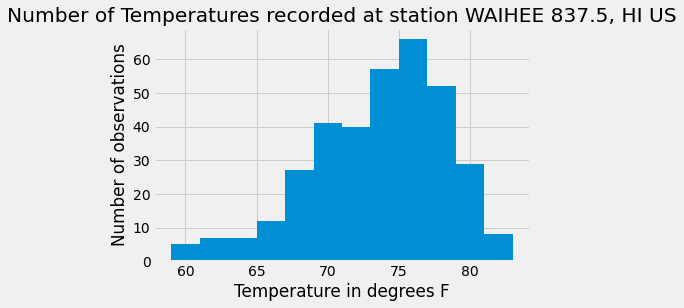

In [18]:
x = temp_df['tobs']
plt.hist(x, bins =12)
plt.title("Number of Temperatures recorded at station WAIHEE 837.5, HI US")
plt.xlabel('Temperature in degrees F')  
plt.ylabel('Number of observations')  
plt.show()

## Bonus Challenge Assignment

In [19]:
session = Session(engine)
june_temps = session.query(Measurement.tobs).filter(extract('month', Measurement.date) == 6).all()
dec_temps = session.query(Measurement.tobs).filter(extract('month', Measurement.date) == 12).all()

stats.ttest_ind(june_temps, dec_temps, equal_var=True)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

# Statistical test
With a p-value so small we reject the null hypothesis and these data sets are statistically significant.  The Student's 
t-test was used as the two data sets do not have the same shape.

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-02-15', '2018-02-28')
trip_temps

[(58.0, 75.29775784753363, 87.0)]

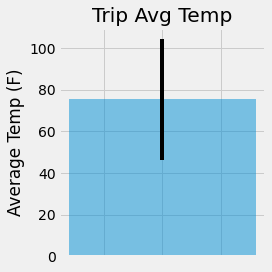

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize= (4,4))
ax.bar(0, trip_temps[0][1],
       yerr=trip_temps[0][2] - trip_temps[0][0],
       align='center',
       alpha=0.5,
       ecolor='black')
ax.set_ylabel('Average Temp (F)')
ax.set_xticklabels('')
ax.set_title('Trip Avg Temp')
plt.tight_layout()

plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rainfall = session.query(func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude,\
    Station.elevation).join(Station, Station.station == Measurement.station)\
    .filter(extract('month', Measurement.date)==2)\
    .filter(extract('day', Measurement.date) >= 15).filter(extract('day', Measurement.date) <= 28)\
    .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()) .all()

station_rainfall

[(25.710000000000015,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (17.909999999999993, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (17.069999999999993,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (9.86, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (9.079999999999997,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (5.399999999999998, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (1.92, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (1.72, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (0.62, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-02-15'
end_date = '2018-02-28'

# Use the start and end date to create a range of dates
date_list = pd.date_range(start_date,end_date).tolist()
ser = pd.Series(date_list)

# Stip off the year and save a list of %m-%d strings
day_list = []
for i in range(0, len(ser)):
    day_list.append(f'{ser.dt.month[i]:02d}-{ser.dt.day[i]:02d}')
                    
# day_list                    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_dict = []
for date in day_list:
    norms = daily_normals(date)
    normals_dict.append({'date': date, 'Min Temp': norms[0][0],
                        'Avg Temp': norms[0][1],
                         'Max Temp': norms[0][2]})
    


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_dict) 
normals_df = normals_df.set_index('date')
normals_df

,Min Temp,Avg Temp,Max Temp
date,,,
02-15,56.0,70.288136,79.0
02-16,59.0,70.482143,76.0
02-17,62.0,70.472727,77.0
02-18,63.0,70.796296,77.0
02-19,60.0,69.339623,77.0
02-20,63.0,70.140351,76.0
02-21,63.0,69.796296,76.0
02-22,60.0,70.157895,83.0
02-23,62.0,70.355932,81.0


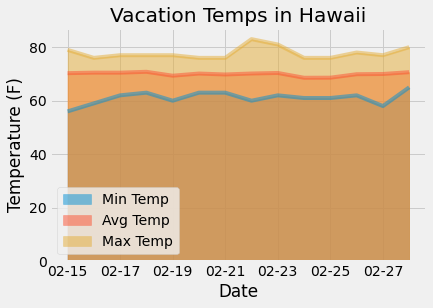

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, title="Vacation Temps in Hawaii")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")
plt.show()
